In [1]:
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data 


from hmmlearn.hmm import GaussianHMM

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:


ticker = "TSLA"
start_date = datetime.date(2003, 7, 1)
end_date = datetime.date.today()
Stocks = data.DataReader(ticker, 'yahoo', start_date, end_date)

Stocks.to_csv("E:\PBL\Pas\HMM-Stock-Predictor-master\data\TSLA_data.csv")

In [3]:
Stocks.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,5.000,3.508,3.800,4.778,93831500.0,4.778
2010-06-30,6.084,4.660,5.158,4.766,85935500.0,4.766
2010-07-01,5.184,4.054,5.000,4.392,41094000.0,4.392
2010-07-02,4.620,3.742,4.600,3.840,25699000.0,3.840
2010-07-06,4.000,3.166,4.000,3.222,34334500.0,3.222


In [4]:
Stocks.shape

(2987, 6)

In [5]:
Stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2987 entries, 2010-06-29 to 2022-05-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2987 non-null   float64
 1   Low        2987 non-null   float64
 2   Open       2987 non-null   float64
 3   Close      2987 non-null   float64
 4   Volume     2987 non-null   float64
 5   Adj Close  2987 non-null   float64
dtypes: float64(6)
memory usage: 163.4 KB


In [6]:
Stocks.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2987.000000,2987.000000,2987.000000,2987.000000,2.987000e+03,2987.000000
mean,150.865647,144.046232,147.603586,147.570557,3.125117e+07,147.570557
std,269.705127,256.853762,263.657359,263.422446,2.785393e+07,263.422446
min,3.326000,2.996000,3.228000,3.160000,5.925000e+05,3.160000
25%,21.062000,19.877999,20.556001,20.460000,1.323965e+07,20.460000
50%,47.782001,46.099998,46.950001,46.980000,2.487450e+07,46.980000
75%,69.760002,67.498001,68.795002,68.792000,3.964475e+07,68.792000
max,1243.489990,1217.000000,1234.410034,1229.910034,3.046940e+08,1229.910034


In [7]:
import datetime
Stocks.reset_index(inplace=True,drop=False)
Stocks.drop(['Open','High','Low','Adj Close'],axis=1,inplace=True)
Stocks['Date'] = Stocks['Date'].apply(datetime.datetime.toordinal)
Stocks = list(Stocks.itertuples(index=False, name=None))

In [8]:
dates = np.array([q[0] for q in Stocks], dtype=int)
end_val = np.array([q[1] for q in Stocks])
volume = np.array([q[2] for q in Stocks])[1:]

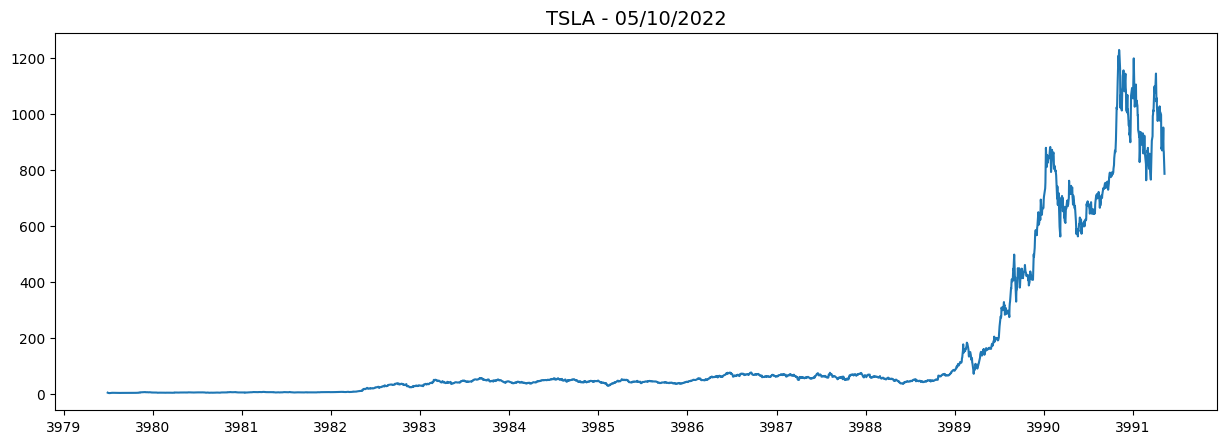

In [9]:
diff = np.diff(end_val)
dates = dates[1:]
end_val = end_val[1:]

X = np.column_stack([diff, volume])
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,end_val,"-")
plt.show()

this is HMMLearn Model and Visualization

In [10]:
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
model.fit(X)

GaussianHMM(n_components=4, n_iter=1000)

In [11]:
hidden_states = model.predict(X)

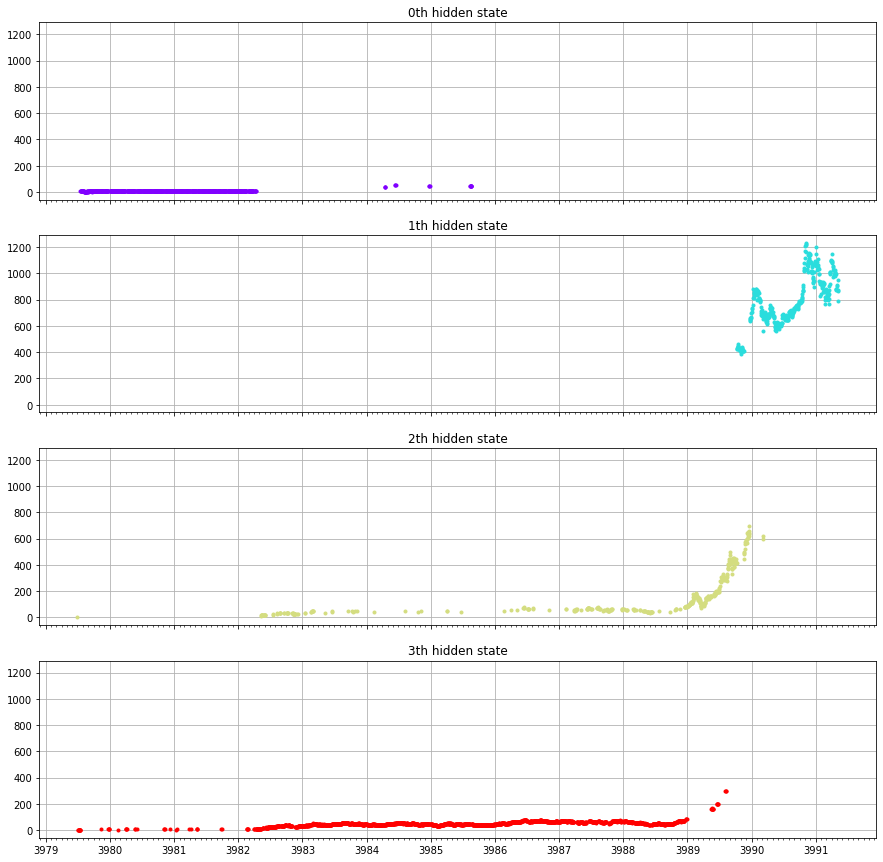

In [12]:
# From HMMLearn Documentation.....

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], end_val[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

In [13]:
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

    Returns        Volume
0  0.004249  6.514816e+06
1  0.471678  2.781882e+07
2  1.109466  7.527335e+07
3  0.112145  3.172014e+07


Make Prediction

In [14]:
lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) 

dates = np.array([q[0] for q in Stocks], dtype=int)

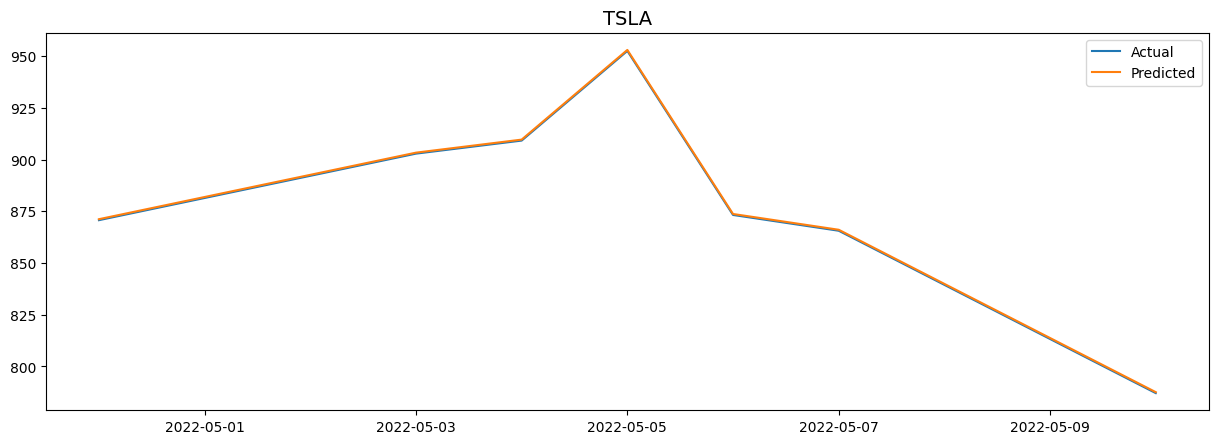

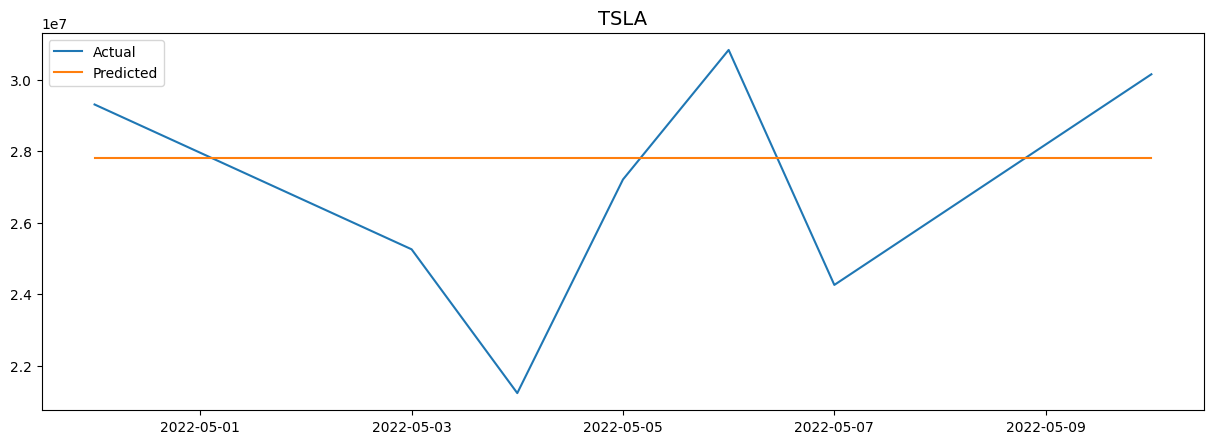

In [15]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = Stocks[-lastN+idx][1]
    volume = Stocks[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,end_val[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()

In [16]:
print('Actual:',end_val[-lastN:], '\n','Prediction:', predicted_prices )

Actual: [870.76000977 902.94000244 909.25       952.61999512 873.2800293
 865.65002441 787.10998535] 
 Prediction: [871.2316875478944, 903.4116802236756, 909.7216777822694, 953.0916728994569, 873.7517070791444, 866.1217021963319, 787.5816631338319]
